# IMDb learning rate tests

## Importing Packages

In [1]:
import matplotlib.pyplot as plt
from google.cloud import storage
from io import BytesIO
import os
from tensorflow.python.lib.io import file_io
import pickle


In [2]:
import utils.model_utils as mu


/home/.conda-env/env_multilingual_class/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Defining functions to simplify the process

In [3]:
def get_metrics(bucket_name, path_history, num_steps):
    '''
    Function to automatically get the relevant variables for plotting the accuracy, loss and learning rates
    
    Args:
        bucket_name: string of the bucket name on GCP
        path_history: string of the path (without the bucket name) to the history per step file
        num_steps: number of steps over all epochs
        
    Returns:
        
    
    '''
    
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(path_history)
    
    with file_io.FileIO('gs://'+bucket_name+'/'+path_history, mode='rb') as f:
        histories_per_step=pickle.load(f)
        
    steps = range(1,num_steps+1)
        
    return histories_per_step.accuracies, histories_per_step.losses, histories_per_step.all_lr_logs, steps

In [4]:
def plot_metrics(metric, steps, ylabel, title, lr_log={}, legend_1="Test 1: Benchmark at 0", legend_2="Test 2: hypothetical learning rates"):
    '''
    Function to automatically plot the three different metric plots
    
    Args:
        metric: list of the chosen metric values for both runs
        steps: list with the number of steps over both epochs
        ylabel: string of the label for the y axis
        title: string of the plot title
        lr_log: list of the learning rates that get printed out for each training step for both runs

    Returns:
        plot for the chosen metric over both runs to compare them
        '''
    plt.style.use("ggplot")

    #plt.figure()
    plt.xlabel("Step #")
    plt.ylabel(ylabel)
    plt.title(title)
    
    plt.plot(steps, metric[0])
    plt.plot(steps, metric[1])
    if lr_log == {}:
        plt.legend([legend_1, legend_2])
    else:
        plt.plot(steps, lr_log)
        plt.legend([legend_1, legend_2, "Test 2: log learning rates"])


## Using the functions for a specific run

In [5]:
bucket = os.environ['BUCKET_NAME']
path_history_run_0a = 'training_model_gcp/tf_bert_classification_lr_0_2020_05_27_114745/history/history_per_step'
path_history_run_0b = 'training_model_gcp/tf_bert_classification_lr_0_2020_05_27_130953/history/history_per_step'
path_history_run_1 = 'training_model_gcp/tf_bert_classification_lr_1_2020_05_27_114837/history/history_per_step'
path_history_run_0001 = 'training_model_gcp/tf_bert_classification_lr_0001_2020_05_27_122643/history/history_per_step'
#path_history_run_1_600 = 'training_model_gcp/tf_bert_classification_lr_5e5_1_600_2020_05_27_171406/history/history_per_step'
path_history_run_1_600 = 'training_model_gcp/tf_bert_classification_lr_3e5_1_600_2020_05_28_072044/history/history_per_step'
#path_history_run_3_200 = 'training_model_gcp/tf_bert_classification_lr_5e5_3_200_2020_05_27_171505/history/history_per_step'
path_history_run_3_200 = 'training_model_gcp/tf_bert_classification_lr_3e5_3_200_2020_05_28_071959/history/history_per_step'


steps_all_epochs = 100
#title = 'Comparison always 0 and from 0.1 to 0'
#title = 'Comparison always 0 and from 1e-4 to 0'

### Comparing two separate runs with lr = 0

Two models were trained on a constant learning rate of 0 over 2 epochs with 50 steps each. This was done to get two different sets of random seeds and to confirm that what we saw on one run also happened on the other.

In [6]:
title = "Comparing two runs with lr=0"

In [7]:
lr_0a_acc, lr_0a_loss, lr_0a_lr, steps = get_metrics(bucket,
                                                  path_history_run_0a,
                                                  steps_all_epochs)

In [8]:
lr_0b_acc, lr_0b_loss, lr_0b_lr, steps = get_metrics(bucket,
                                                  path_history_run_0b,
                                                  steps_all_epochs)

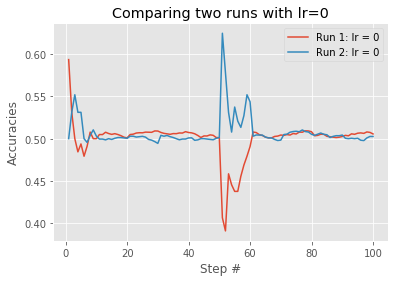

In [9]:
plot_metrics([lr_0a_acc, lr_0b_acc], steps, 'Accuracies', title, legend_1="Run 1: lr = 0", legend_2="Run 2: lr = 0")

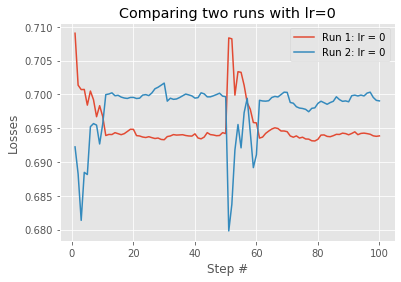

In [10]:
plot_metrics([lr_0a_loss, lr_0b_loss], steps, 'Losses', title, legend_1="Run 1: lr = 0", legend_2="Run 2: lr = 0")

As seen above, the accuracy and loss jumps at the beginning of the second epoch (step 51). We need to find out why this is happening.

### 1 Epoch, 600 Steps, Constant learning rate = 3e-5

To investigate this issue, we experimented with two longer runs. Both models run over a total of 600 steps whereas the first model does this in one epoch and the second model does it in three. Hereby, the models otherwise share the same parameters. Differences between the models can therefore only be attributed to random chance and the effect of the epoch-step-ratio. If there are significant jumps at the beginning of the epochs, there is something going on that needs to be investigated.

In [11]:
#path_history_run_1_600 = 'training_model_gcp/tf_bert_classification_lr_5e5_1_600_2020_05_27_171406/history/history_per_step'

steps_test = 600

In [12]:
lr_1_600_acc, lr_1_600_loss, lr_1_600_lr, steps = get_metrics(bucket,
                                                  path_history_run_1_600,
                                                  steps_test)

In [13]:
#plot_metrics([lr_0a_acc, lr_0b_acc], steps, 'Accuracies', title, legend_1="Run 1: lr = 0", legend_2="Run 2: lr = 0")

Text(0.5, 1.0, '1 Epoch, 600 Steps, lr = 3e-5')

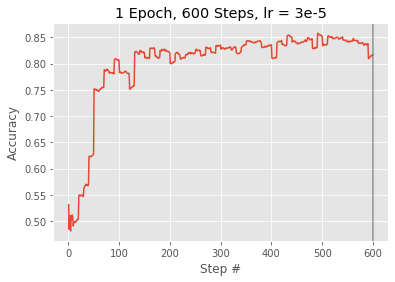

In [14]:
plt.style.use("ggplot")

#plt.figure()
plt.xlabel("Step #")
plt.ylabel("Accuracy")
plt.axvline(600, 0, 1, label='pyplot vertical line', c='k', alpha=0.4)

plt.plot(steps, lr_1_600_acc)

plt.title("1 Epoch, 600 Steps, lr = 3e-5")

Text(0.5, 1.0, '1 Epoch, 600 Steps, lr = 3e-5')

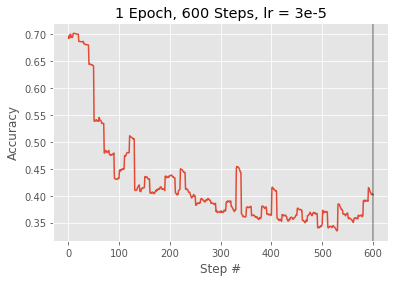

In [15]:
plt.style.use("ggplot")

#plt.figure()
plt.xlabel("Step #")
plt.ylabel("Accuracy")

plt.plot(steps, lr_1_600_loss)
plt.axvline(600, 0, 1, label='pyplot vertical line', c='k', alpha=0.4)

plt.title("1 Epoch, 600 Steps, lr = 3e-5")

Text(0.5, 1.0, '1 Epoch, 600 Steps, lr = 3e-5')

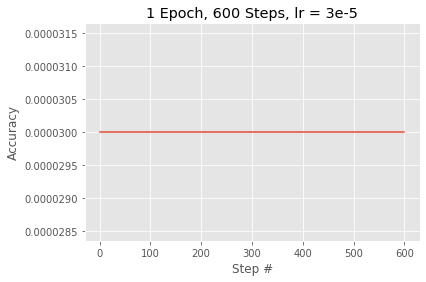

In [16]:
plt.style.use("ggplot")

#plt.figure()
plt.xlabel("Step #")
plt.ylabel("Accuracy")

plt.plot(steps, lr_1_600_lr)

plt.title("1 Epoch, 600 Steps, lr = 3e-5")

### 3 Epochs, 200 Steps, Constant learning rate = 3e-5

In [17]:
#path_history_run_3_200 = 'training_model_gcp/tf_bert_classification_lr_5e5_3_200_2020_05_27_171505/history/history_per_step'


In [18]:
lr_3_200_acc, lr_3_200_loss, lr_3_200_lr, steps = get_metrics(bucket,
                                                  path_history_run_3_200,
                                                  steps_test)

Text(0.5, 1.0, '3 Epochs, 200 Steps, lr = 3e-5')

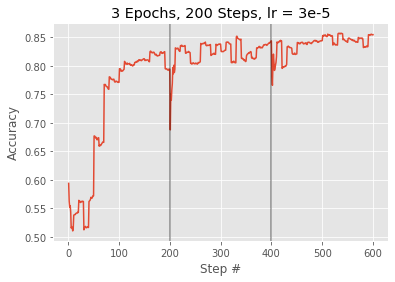

In [19]:
plt.style.use("ggplot")

#plt.figure()
plt.xlabel("Step #")
plt.ylabel("Accuracy")

plt.plot(steps, lr_3_200_acc)
plt.axvline(200, 0, 1, label='pyplot vertical line', c='k', alpha=0.4)
plt.axvline(400, 0, 1, label='pyplot vertical line', c='k', alpha=0.4)
#plt.axvline(600, 0, 1, label='pyplot vertical line', c='k')

plt.title("3 Epochs, 200 Steps, lr = 3e-5")

These plots show definite jumps at the beginning of each epoch which cannot be seen in the accuracy and loss plots above with just one epoch. We therefore conclude that there must be some reinitialisation or reshuffling by Keras in the background which we need to investigate.

Text(0.5, 1.0, '3 Epochs, 200 Steps, lr = 3e-5')

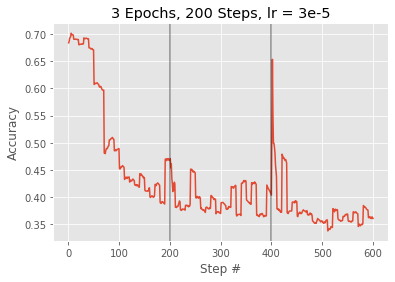

In [20]:
plt.style.use("ggplot")

#plt.figure()
plt.xlabel("Step #")
plt.ylabel("Accuracy")

plt.plot(steps, lr_3_200_loss)
plt.axvline(200, 0, 1, label='pyplot vertical line', c='k', alpha=0.4)
plt.axvline(400, 0, 1, label='pyplot vertical line', c='k', alpha=0.4)

plt.title("3 Epochs, 200 Steps, lr = 3e-5")

Text(0.5, 1.0, '3 Epochs, 200 Steps, lr = 3e-5')

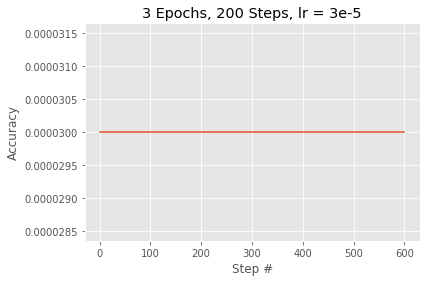

In [21]:
plt.style.use("ggplot")

#plt.figure()
plt.xlabel("Step #")
plt.ylabel("Accuracy")

plt.plot(steps, lr_3_200_lr)

plt.title("3 Epochs, 200 Steps, lr = 3e-5")

### Both of these runs overlapped

In [22]:
title = "Accuracies for a constant lr of 3e-5"

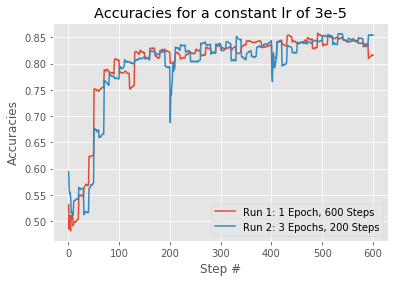

In [23]:
plot_metrics([lr_1_600_acc, lr_3_200_acc], steps, 'Accuracies', title, legend_1="Run 1: 1 Epoch, 600 Steps", legend_2="Run 2: 3 Epochs, 200 Steps")

Except for the jumps, the runs look fairly similar which makes sense given the shared parameters.

### Comparing the "zero"-run with the 0.1-run

We conducted these experiments to solve an underlying problem with the learning rate. In the code, we implemented a learning rate decay which can be adapted to all kinds of decay functions and can be called after a specified number of batches using a adapted version of the LearningRateScheduler class. The default implementation of the learning rate scheduler is designed to work only per epoch which is not extremely helpful in our NLP case. 

This custom decay that we implemented updates the learning rate in the optimizer function of keras at the specified batch number and the updated value can be accessed at each point in training. However, the automatic display of the learning rate by keras at each batch end shows different numbers except for the beginning of the epoch. (We didn't find a way to extract the 'false' learning rate.)

Due to these discrepancies, we tried to investigate which of the learning rates is actually used during training. Following, several models are trained by setting the learning rate of the first batch to some value and then dropping the learning rate to 0 for batch 2 until the end of training. If the 'false' learning rates were used, the model would follow a somewhat exponential decay and should be significantly different from a model that we trained solely on a learning rate equal to 0.

In [24]:
title = "Test 1: lr constant at 0; Test 2: lr0=0.1, then 0"

In [25]:
lr_0_lr_logs = [0]*steps_all_epochs
lr_1_lr_logs = [0.1, 0.05, 0.033, 0.025, 0.02, 0.0167, 0.0143, 0.0125, 0.0111, 0.01,
                0.0091, 0.0083, 0.0077, 0.0071, 0.0067, 0.0063, 0.0059, 0.0056, 0.0053, 0.0050, 
                0.0048, 0.0045, 0.0043, 0.0042, 0.0040, 0.0038, 0.0037, 0.0036, 0.0034, 0.0033, 
                0.0032, 0.0031, 0.0030, 0.0029, 0.0029, 0.0028, 0.0027, 0.0026, 0.0026, 0.0025, 
                0.0024, 0.0024, 0.0023, 0.0023, 0.0022, 0.0022, 0.0021, 0.0021, 0.0020, 0.0020, 
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [26]:
lr_1_acc, lr_1_loss, lr_1_lr, steps = get_metrics(bucket,
                                                  path_history_run_1,
                                                  steps_all_epochs)

In [27]:
lr_0a_acc

[0.59375,
 0.53125,
 0.5,
 0.484375,
 0.4937500059604645,
 0.4791666567325592,
 0.4910714328289032,
 0.5078125,
 0.5,
 0.5,
 0.5049212574958801,
 0.5048449635505676,
 0.5076335668563843,
 0.5061089992523193,
 0.5050926208496094,
 0.5059306621551514,
 0.5049460530281067,
 0.5035461187362671,
 0.501748263835907,
 0.5008620619773865,
 0.5049212574958801,
 0.505329430103302,
 0.5066794157028198,
 0.5070488452911377,
 0.5069444179534912,
 0.50775545835495,
 0.5076438784599304,
 0.507535457611084,
 0.5091783404350281,
 0.5090517401695251,
 0.5073819160461426,
 0.5062984228134155,
 0.5057252049446106,
 0.505169153213501,
 0.5060185194015503,
 0.5059306621551514,
 0.5067446231842041,
 0.5066489577293396,
 0.5083041787147522,
 0.5073275566101074,
 0.5068897604942322,
 0.5058139562606812,
 0.5038167834281921,
 0.5014097690582275,
 0.5032407641410828,
 0.5031934380531311,
 0.5044963955879211,
 0.5039893388748169,
 0.501311182975769,
 0.5012931227684021,
 0.40625,
 0.390625,
 0.4583333432674408,
 

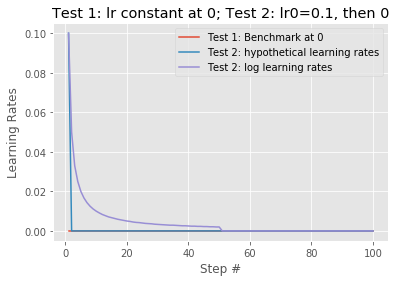

In [28]:
plot_metrics([lr_0a_lr, lr_1_lr], steps, 'Learning Rates', title, lr_log=lr_1_lr_logs)

This plot shows that at the latest, for the second epoch the learning rate is set to zero. This is the case because even the 'false' learning rate is updated at the beginning of every epoch.

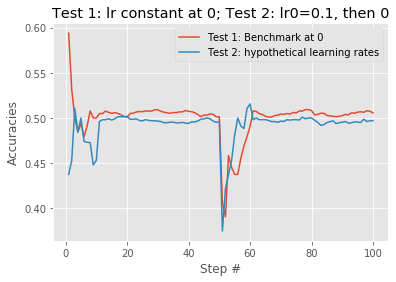

In [29]:
plot_metrics([lr_0a_acc, lr_1_acc], steps, 'Accuracies', title)

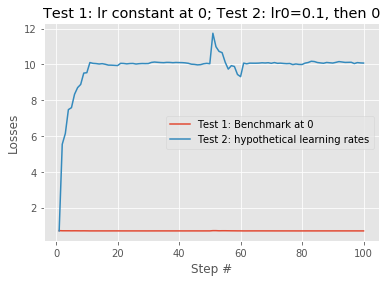

In [30]:
plot_metrics([lr_0a_loss, lr_1_loss], steps, 'Losses', title)

We agreed that these findings were not conclusive enough to say for sure which learning rate was used.

### Comparing the "zero"-run with the 0.0001-run

We repeated the experiment with a smaller learning rate to see if the value of the learning rate was an issue.

In [31]:
title = "Test 1: lr constant at 0; Test 2: lr0=0.0001, then 0"

In [32]:
# manually collected from the job output logs
lr_0_lr_logs = [0]*steps_all_epochs
lr_0001_lr_logs = [1.0000e-4, 5.0000e-5, 3.3333e-5, 2.5000e-5, 2.0000e-5, 1.6667e-5, 1.4286e-5, 1.2500e-5, 1.1111e-5, 1.0000e-5,
                   9.0909e-6, 8.3333e-6, 7.6923e-6, 7.1429e-6, 6.6667e-6, 6.2500e-6, 5.8824e-6, 5.5556e-6, 5.2632e-6, 5.0000e-6,
                   4.7619e-6, 4.5455e-6, 4.3478e-6, 4.1667e-6, 4.0000e-6, 3.8462e-6, 3.7037e-6, 3.5714e-6, 3.4483e-6, 3.3333e-6, 
                   3.2258e-6, 3.1250e-6, 3.0303e-6, 2.9412e-6, 2.8571e-6, 2.7778e-6, 2.7027e-6, 2.6316e-6, 2.5641e-6, 2.5000e-6, 
                   2.4390e-6, 2.3810e-6, 2.3256e-6, 2.2727e-6, 2.2222e-6, 2.1739e-6, 2.1277e-6, 2.0833e-6, 2.0408e-6, 2.0000e-6,
                   0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [33]:
lr_0001_acc, lr_0001_loss, lr_0001_lr, steps = get_metrics(bucket,
                                                  path_history_run_0001,
                                                  steps_all_epochs)

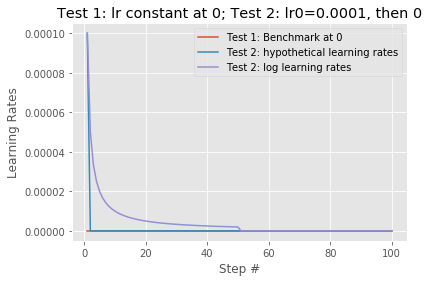

In [34]:
#plot_metrics([lr_0_lr, lr_1_lr], steps, 'Learning Rates', lr_log=lr_1_lr_logs)
plot_metrics([lr_0a_lr, lr_0001_lr], steps, 'Learning Rates', title, lr_log=lr_0001_lr_logs)

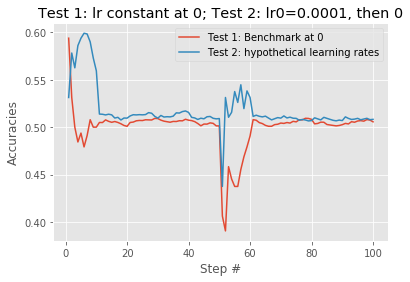

In [35]:
plot_metrics([lr_0a_acc, lr_0001_acc], steps, 'Accuracies', title)

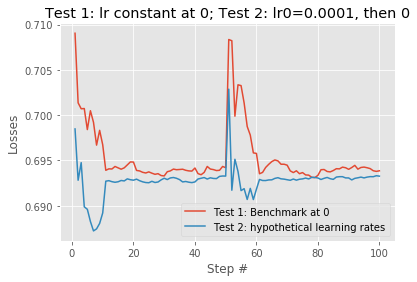

In [36]:
plot_metrics([lr_0a_loss, lr_0001_loss], steps, 'Losses', title)

## Old Code

In [37]:
!gsutil ls gs://multilingual_text_classification/training_model_gcp/tf_bert_classification_lr_0_2020_05_27_065149/history/history_per_step

gs://multilingual_text_classification/training_model_gcp/tf_bert_classification_lr_0_2020_05_27_065149/history/history_per_step


In [38]:

client = storage.Client()

bucket = client.bucket(os.environ['BUCKET_NAME'])
blob = bucket.blob('training_model_gcp/tf_bert_classification_lr_0_2020_05_27_065149/history/history_per_step')
blob

<Blob: multilingual_text_classification, training_model_gcp/tf_bert_classification_lr_0_2020_05_27_065149/history/history_per_step, None>

In [39]:
with file_io.FileIO('gs://'+os.environ['BUCKET_NAME']+'/training_model_gcp/tf_bert_classification_lr_0_2020_05_27_065149/history/history_per_step', mode='rb') as f:
    histories_per_step=pickle.load(f)

In [40]:
histories_per_step.losses

[0.6868826746940613,
 0.6908368468284607,
 0.6894741654396057,
 0.6899018287658691,
 0.6896375417709351,
 0.693556547164917,
 0.6953176856040955,
 0.6963809728622437,
 0.6962748765945435,
 0.6967212557792664,
 0.7026018500328064,
 0.6916979551315308,
 0.6950526833534241,
 0.6963711977005005,
 0.696386456489563,
 0.696911096572876,
 0.6957680583000183,
 0.6942991614341736,
 0.6959212422370911,
 0.6945924162864685]

In [41]:
#mu.History_per_steps_trained_model(histories_per_step.steps, 
#                                                                   histories_per_step.losses, 
#                                                                   histories_per_step.accuracies, 
#                                                                   histories_per_step.all_lr_logs)

In [42]:
steps = [1, 2, 3, 4, 5, 6]

lr_0_acc = [0.4, 0.5, 0.5, 0.4, 0.5, 0.56666667]
lr_0_loss = [0.7119, 0.6982, 0.7016, 0.72, 0.7072, 0.6886]
lr_0_lr = [0, 0, 0, 0, 0, 0]

lr_1_acc = [0.30000001192092896,
 0.30000001192092896,
 0.4000000059604645,
 0.4000000059604645,
 0.550000011920929,
 0.6000000238418579]
lr_1_loss = [0.7935468554496765,
 3.3114376068115234,
 3.3063154220581055,
 5.293379783630371,
 3.9562346935272217,
 3.404308319091797]
lr_1_lr = [0.1, 0.0, 0.0, 0.0, 0.0, 0.0]
lr_1_lr_log = [0.1, 0.05, 0.033, 0, 0, 0]


lr_1_10_log = [0.1, 0.05, 0.033, 0.0250, 0.02, 0, 0, 0, 0, 0]


In [43]:
lr_0_loss = histories_per_step.losses

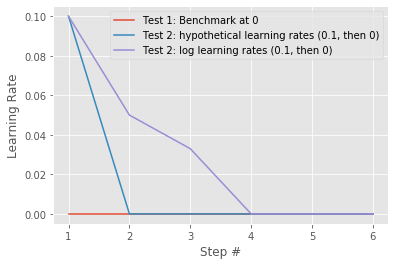

In [44]:
plt.style.use("ggplot")

#plt.figure()
plt.xlabel("Step #")
plt.ylabel("Learning Rate")

plt.plot(steps, lr_0_lr)
plt.plot(steps, lr_1_lr)
plt.plot(steps, lr_1_lr_log)

plt.legend(["Test 1: Benchmark at 0", "Test 2: hypothetical learning rates (0.1, then 0)", "Test 2: log learning rates (0.1, then 0)"])

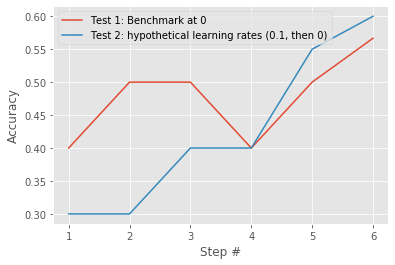

In [45]:
#plt.figure()
plt.xlabel("Step #")
plt.ylabel("Accuracy")

plt.plot(steps, lr_0_acc)
plt.plot(steps, lr_1_acc)

plt.legend(["Test 1: Benchmark at 0", "Test 2: hypothetical learning rates (0.1, then 0)"])

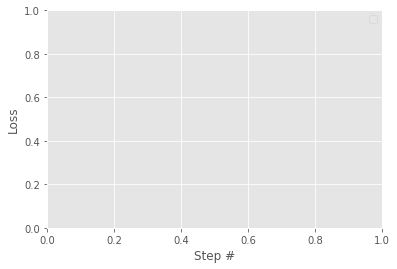

In [46]:
#plt.figure()
plt.xlabel("Step #")
plt.ylabel("Loss")

#plt.plot(steps, lr_0_loss)
#plt.plot(steps, lr_1_loss)

plt.legend(["Test 1: Benchmark at 0", "Test 2: hypothetical learning rates (0.1, then 0)"])